In [33]:

    decoded_a = 23
    decoded_b = 17
    ascii_a = decoded_a + 65
    ascii_b = decoded_b + 65
    sum_pred = ascii_a + ascii_b
    while sum_pred > 122:
        sum_pred -= 65
    print(sum_pred)
    print(chr(sum_pred))
"""
23 + 17
18 + 23
13 + 20
12 + 11
19 + 14
"""

105
i


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# Setting a random seed for reproducibility
np.random.seed(42)
split_ratio = 0.8
train_file_path = 'sign_mnist_train2.csv'
test_file_path = 'testcustom.csv'

###################### -- HELPER FUNCTIONS -- ######################

def separate_test_sets(file_path):
    test_data = pd.read_csv(file_path)
    test_a_columns = [col for col in test_data.columns if 'pixel_a' in col]
    test_b_columns = [col for col in test_data.columns if 'pixel_b' in col]
    test_a = test_data[test_a_columns]
    test_b = test_data[test_b_columns]
    test_a.columns = [col.replace('_a', '') for col in test_a.columns]
    test_b.columns = [col.replace('_b', '') for col in test_b.columns]
    return test_a, test_b

def predict_and_merge(model, test_a, test_b):
    preds_a = model.compute_predictions(test_a)
    preds_b = model.compute_predictions(test_b)
    merged_predictions = []
    for i in range(len(preds_a)):
        # Replacing 9 back to 24 if needed
        decoded_a = preds_a[i] if preds_a[i] != 9 else 24
        decoded_b = preds_b[i] if preds_b[i] != 9 else 24

        ascii_a = decoded_a + 65
        ascii_b = decoded_b + 65
        sum_pred = ascii_a + ascii_b
        while sum_pred > 122:
            sum_pred -= 65
        merged_predictions.append((i, chr(int(sum_pred))))
    return merged_predictions

def save_predictions_to_csv(filename, predictions):
    with open(filename, 'w') as file:
        file.write("id,label\n")
        for id, label in predictions:
            file.write(f"{id},{label}\n")

def plot_results_XGB(results):
    learning_rates = [x[0] for x in results]
    max_depths = [x[1] for x in results]
    accuracies = [x[2] for x in results]
    plt.figure(figsize=(10, 6))
    for lr in set(learning_rates):
        specific_lr_depths = [depth for depth, l_rate in zip(max_depths, learning_rates) if l_rate == lr]
        specific_acc = [acc for acc, l_rate in zip(accuracies, learning_rates) if l_rate == lr]
        plt.plot(specific_lr_depths, specific_acc, label=f'Learning Rate {lr}')
    plt.title('Accuracy for different max depths and learning rates')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



###################### -- Data Handling -- ######################

mnist_sign_train = pd.read_csv(train_file_path)
mnist_sign_train['label'] = mnist_sign_train['label'].replace(24, 9)
mnist_sign_train = mnist_sign_train.sample(frac=1).reset_index(drop=True)
labels = mnist_sign_train['label'].values
features = mnist_sign_train.drop('label', axis=1).values

features_normalized = features / 255.0
split_index = int(split_ratio * len(features_normalized))
train_data, validation_data = features_normalized[:split_index], features_normalized[split_index:]
train_labels, validation_labels = labels[:split_index], labels[split_index:]

train_mean = train_data.mean(axis=0)
train_std = train_data.std(axis=0)
train_data_normalized = (train_data - train_mean) / train_std
validation_data_normalized = (validation_data - train_mean) / train_std

test_a, test_b = separate_test_sets(test_file_path)
normalized_test_a = (test_a.values / 255.0 - train_mean) / train_std
normalized_test_b = (test_b.values / 255.0 - train_mean) / train_std

###################### -- XGBOOST Implementation -- ######################

class XGBoostClassifier:
    def __init__(self, max_depth, eta, num_class):
        self.params = {
            'objective': 'multi:softmax',
            'num_class': num_class,
            'booster': 'gbtree',
            'eval_metric': 'merror',
            'eta': eta,
            'max_depth': max_depth,
        }

    def train(self, train_data, train_labels, validation_data, validation_labels):
        dtrain = xgb.DMatrix(train_data, label=train_labels)
        dval = xgb.DMatrix(validation_data, label=validation_labels)
        watchlist = [(dtrain, 'train'), (dval, 'validation')]
        self.model = xgb.train(self.params, dtrain, num_boost_round=200, evals=watchlist, early_stopping_rounds=20, verbose_eval=False)

    def compute_predictions(self, data):
        ddata = xgb.DMatrix(data)
        return self.model.predict(ddata)

    def compute_accuracy(self, preds, labels):
        return np.mean(preds == labels)

###################### -- TRAINING -- ######################

def startXGBOOST(train_data_normalized, train_labels, validation_data_normalized, validation_labels):
    learning_rates = [0.1]
    max_depths = [3]
    results_XGB = []
    best_acc_xgb = 0
    best_lr = None
    best_depth = None
    num_class = len(np.unique(train_labels))

    for lr in learning_rates:
        for depth in max_depths:
            xgb_model = XGBoostClassifier(max_depth=depth, eta=lr, num_class=num_class)
            xgb_model.train(train_data_normalized, train_labels, validation_data_normalized, validation_labels)
            val_preds = xgb_model.compute_predictions(validation_data_normalized)
            acc = xgb_model.compute_accuracy(val_preds, validation_labels)
            if acc > best_acc_xgb:
                best_acc_xgb = acc
                best_lr = lr
                best_depth = depth
            results_XGB.append((lr, depth, acc))

    #plot_results_XGB(results_XGB)

    best_xgb_model = XGBoostClassifier(max_depth=best_depth, eta=best_lr, num_class=num_class)
    best_xgb_model.train(train_data_normalized, train_labels, validation_data_normalized, validation_labels)

    return best_xgb_model

#best_xgb_model = startXGBOOST(train_data_normalized, train_labels, validation_data_normalized, validation_labels)

#final_predictions = predict_and_merge(best_xgb_model, normalized_test_a, normalized_test_b)

#save_merged_predictions_to_csv("merged_predictions.csv", final_predictions)


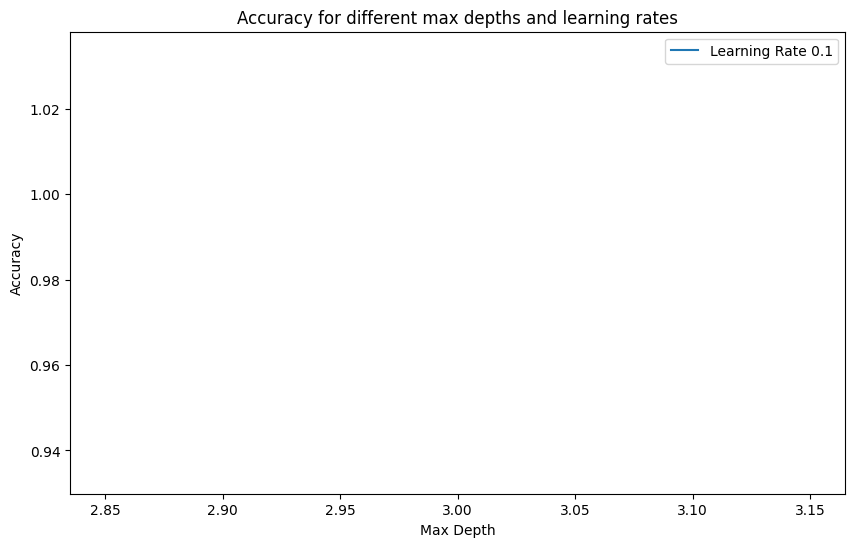

preds :  3.0 , 6.0  decoded :  3.0 , 6.0
preds :  2.0 , 22.0  decoded :  2.0 , 22.0
preds :  1.0 , 5.0  decoded :  1.0 , 5.0
preds :  13.0 , 16.0  decoded :  13.0 , 16.0
preds :  10.0 , 17.0  decoded :  10.0 , 17.0
preds :  17.0 , 23.0  decoded :  17.0 , 23.0
preds :  19.0 , 12.0  decoded :  19.0 , 12.0
preds :  16.0 , 0.0  decoded :  16.0 , 0.0
preds :  4.0 , 15.0  decoded :  4.0 , 15.0
preds :  9.0 , 0.0  decoded :  24 , 0.0
preds :  3.0 , 3.0  decoded :  3.0 , 3.0
preds :  2.0 , 19.0  decoded :  2.0 , 19.0
preds :  4.0 , 7.0  decoded :  4.0 , 7.0
preds :  0.0 , 0.0  decoded :  0.0 , 0.0
preds :  0.0 , 0.0  decoded :  0.0 , 0.0
preds :  4.0 , 19.0  decoded :  4.0 , 19.0
preds :  14.0 , 9.0  decoded :  14.0 , 24
preds :  13.0 , 4.0  decoded :  13.0 , 4.0
preds :  10.0 , 8.0  decoded :  10.0 , 8.0
preds :  4.0 , 16.0  decoded :  4.0 , 16.0
preds :  5.0 , 15.0  decoded :  5.0 , 15.0
preds :  8.0 , 8.0  decoded :  8.0 , 8.0
preds :  13.0 , 4.0  decoded :  13.0 , 4.0
preds :  19.0 , 22.0 

In [25]:
best_xgb_model = startXGBOOST(train_data_normalized, train_labels, validation_data_normalized, validation_labels)

final_predictions = predict_and_merge(best_xgb_model, normalized_test_a, normalized_test_b)

save_predictions_to_csv("merged_predictions.csv", final_predictions)
